# Converting Images to Point Cloud
This notebook demonstrates how to convert images to point clouds using the [Open3D](http://www.open3d.org/) library. The images are first converted to depth maps using a pre-trained model, and then the depth maps are converted to point clouds. The point clouds are then visualized using Open3D.

In [47]:
import os
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np 
import copy
from numpy import asarray
from PIL import Image
from transformers import pipeline

#### Import data
The data is imported from the `input` directory. These images are transformed to depth maps (saved in the `depth` directory) and then to point clouds (saved in the `point_cloud` directory).

In [48]:
data_set_name = 'cuadra'
input_path = "input/" + data_set_name + "/"
output_dir = "output/" + data_set_name + "/"
output_dir_depth = output_dir + "depth/"
output_dir_pcd = output_dir + "pcd/"


In [49]:
dir_list = os.listdir(input_path)
original_paths = []
depth_map_pahts = []
for filename in dir_list:
    if filename != None and filename.endswith(('.png')):
        image_path = input_path + filename
        output_path = output_dir_depth + filename.split('.')[0] + '_depth.png'
        original_paths.append(image_path)
        depth_map_pahts.append(output_path)
df_paths = pd.DataFrame({'Original': original_paths, 'DepthMap': depth_map_pahts})

#### Transform images to depth maps
Function to convert images to depth maps:

In [50]:
def make_8bit_image(depth_map_array):
    max_pixel_value = depth_map_array.max()
    depth_map_array = depth_map_array / max_pixel_value * 255
    depth_map_array = depth_map_array.astype('uint8')
    return depth_map_array

def save_image(depth_map_array, output_path):
    image = Image.fromarray(depth_map_array)
    image.save(output_path)

def img_to_depth_map(depth_estimation_pipeline, image_path, output_path):
    # load input image
    image = Image.open(image_path)
    if image.size != (640, 480):
        image = image.resize((640, 480))

    # Realizar la estimación de profundidad en la imagen de entrada
    depth_map = depth_estimation_pipeline(image)

    # access the predicted depth map
    depth_map_tensor = depth_map['predicted_depth']

    # Convertir el tensor de profundidad en una matriz numpy y mostrarlo
    depth_map_array = depth_map_tensor[0].numpy()
    depth_map_array = make_8bit_image(depth_map_array)

    # show_depth_map(depth_map_array)
    save_image(depth_map_array, output_path)

Load the depth-estimation pipeline

In [51]:
depth_estimation_pipeline = pipeline("depth-estimation", model="vinvino02/glpn-nyu")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Then apply the pipeline to the images in the `input` directory and save the depth maps in the `depth` directory.

In [52]:
df_paths.apply(lambda row: img_to_depth_map(depth_estimation_pipeline, row["Original"], row['DepthMap']), axis=1)

0    None
1    None
2    None
dtype: object

#### Visualize Depth Map Results

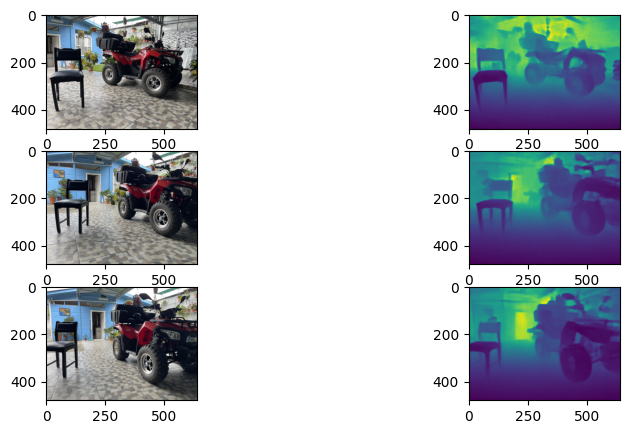

In [53]:
#display images and its maps
df_sample = df_paths.sample(3)
x, y = df_sample.shape
fig, axs = plt.subplots(x, y, figsize=(10, 5))
for i, (index, row) in enumerate(df_sample.iterrows()):
    original_image = imread(row['Original'])
    depth_map = imread(row['DepthMap'])
    axs[i, 0].imshow(original_image)
    axs[i, 1].imshow(depth_map)

#### Transform Depth Maps into Point Clouds

Build the path to the point cloud directory for every image in the `depth` directory.

In [54]:
def build_pc_output_path(image_path):
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]
    return os.path.join(output_dir_pcd, image_name + '.ply')

df_paths["PointCloud"] = df_paths["Original"].apply(build_pc_output_path)


Function to convert depth maps to point clouds.
The camera parameteres doesn't correspond to the real camera parameters, but they are used to generate the point cloud.

In [55]:
def extract_color_image(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = asarray(img)
    img = img/255.0 # normalize RGB values to [0, 1]

    height, width, channels = img.shape
    length = height * width

    color_list = img.reshape((length, channels)) # array of RGB values
    return color_list

In [56]:
def depth_to_pcd(depth_path, original_path, pcd_path):
    # Depth camera parameters:
    FX_DEPTH = 5.8262448167737955e+02
    FY_DEPTH = 5.8269103270988637e+02
    CX_DEPTH = 3.1304475870804731e+02
    CY_DEPTH = 2.3844389626620386e+02
    
    depth_image = Image.open(depth_path).convert('L')
    depth_image = asarray(depth_image)
    
    # get depth resolution:
    height, width = depth_image.shape
    length = height * width
    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)
    # rechape depth image
    z = depth_image.reshape(length)
    # compute pcd:
    pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                 (jj - CY_DEPTH) * z / FY_DEPTH,
                 z]).reshape((length, 3))

    pcd_o3d = o3d.geometry.PointCloud()
    pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
    colors = extract_color_image(original_path)
    pcd_o3d.colors = o3d.utility.Vector3dVector(colors)

    o3d.io.write_point_cloud(pcd_path, pcd_o3d)


Transform the depth maps to point clouds and save them in the `point_cloud` directory.

In [57]:
y = df_paths.apply(lambda row: depth_to_pcd(row["DepthMap"], row["Original"], row["PointCloud"]), axis=1)

#### Visualize Sample Point Clouds

We take a random sample and visualize the point clouds.

In [58]:
sample = df_paths.sample(1)

We can add the original image color to the point cloud.

In [59]:
path_to_pcd = sample["PointCloud"].values[0]
path_to_original = sample["Original"].values[0]

pcd = o3d.io.read_point_cloud(path_to_pcd)
colors = extract_color_image(path_to_original)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])
# o3d.visualization.draw_plotly([pcd])

### Global registration FPFH

In [60]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    # o3d.visualization.draw_plotly([source_temp, target_temp])
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [61]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal) 
    #Noramls are used to calculate the FPFH features
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [62]:
source = o3d.io.read_point_cloud(df_paths["PointCloud"].values[0])
target = o3d.io.read_point_cloud(df_paths["PointCloud"].values[1])

Preprocess pcd to make registration faster.

In [63]:
voxel_size=4
# random transformation matrix
trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
source.transform(trans_init)
draw_registration_result(source, target, np.identity(4))
source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
print("points in source_down: %i" %len(source_down.points) )
print("points in target_down: %i" %len(target_down.points) )

:: Downsample with a voxel size 4.000.
:: Estimate normal with search radius 8.000.
:: Compute FPFH feature with search radius 20.000.
:: Downsample with a voxel size 4.000.
:: Estimate normal with search radius 8.000.
:: Compute FPFH feature with search radius 20.000.
points in source_down: 5926
points in target_down: 8759


In [64]:
# o3d.visualization.draw_geometries([source_down])

RANSAC registration.

In [65]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, 
        source_fpfh, target_fpfh, 
        True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        ransac_n = 3, 
        checkers = [ #Pruning, points that pass the pruning will be subject to RANSAC
            #Checking if the edeges of source and target are about 0.9 of each other
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9), 
            #Checking if the distance between the points is less than the threshold
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold) 
        ], 
        criteria = o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999)) #max_iter, confidence
    return result.transformation

In [66]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 4.000,
   we use a liberal distance threshold 6.000.
[[-3.85693547e-01 -8.58692489e-01  3.37472512e-01 -3.89390280e+01]
 [-7.41310128e-01  5.06179300e-01  4.40728727e-01  1.45472156e+02]
 [-5.49272047e-01 -8.01855653e-02 -8.31787529e-01  2.52805954e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Local registration ICP

In [67]:
threshold=0.02
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, result_ransac,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
draw_registration_result(source, target, reg_p2p.transformation)

RegistrationResult with fitness=6.510417e-06, inlier_rmse=5.958644e-03, and correspondence_set size of 2
Access transformation to get result.
